# Single models

## Decision Tree

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
class ModelManager:
    def __init__(self, train_data, test_data, features_to_keep, window_size, target_step):
        self.train_data = train_data
        self.test_data = test_data
        self.features_to_keep = features_to_keep
        self.window_size = window_size
        self.target_step = target_step
        self.models = {}  # Store trained models
        self.results = {}  # Store results like y_pred for each model
    
    def create_sliding_window(self, data):
        X, y = [], []
        for i in range(len(data) - self.window_size - self.target_step):
            X.append(data.iloc[i:i+self.window_size, 1:].values.flatten())  
            y.append(data['Load'].iloc[i+self.window_size+self.target_step])  
        return np.array(X), np.array(y)
    
    def preprocess_data(self):
        X_train, y_train = self.create_sliding_window(self.train_data)
        X_test, y_test = self.create_sliding_window(self.test_data)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test
    
    def train_model(self, model_name, param_dist, n_estimators, random_state, X_train, y_train):
        tree_model = DecisionTreeRegressor(random_state=random_state)
        bagging_tree = BaggingRegressor(estimator=tree_model, n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
        random_search_tree = RandomizedSearchCV(
            bagging_tree, param_distributions=param_dist, n_iter=80,
            scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=random_state, n_jobs=-1
        )
        random_search_tree.fit(X_train, y_train)
        self.models[model_name] = random_search_tree.best_estimator_
        return random_search_tree.best_estimator_
    
    def predict(self, model_name, X_test, y_test):
        model = self.models.get(model_name)
        if not model:
            raise ValueError(f"Model '{model_name}' is not trained yet.")
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        self.results[model_name] = {
            "y_pred": y_pred,
            "metrics": {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "MAPE": mape
            }
        }
    
    def plot_results(self, model_name, y_test):
        y_pred = self.results[model_name]["y_pred"]
        plt.figure(figsize=(8, 3))
        plt.plot(y_test, label='Actual', linewidth=2)
        plt.plot(y_pred, label='Predicted', linestyle='--')
        plt.legend()
        plt.xlabel("Time (15-min interval)")
        plt.ylabel("Load (kW)")
        plt.title(f"Actual vs Predicted Load - {model_name}")
        plt.grid()
        plt.show()
    
    def summarize_results(self):
        summary = pd.DataFrame([
            {
                "Model": model_name,
                **self.results[model_name]["metrics"]
            }
            for model_name in self.results.keys()
        ])
        print(summary)
        return summary

Fitting 3 folds for each of 80 candidates, totalling 240 fits


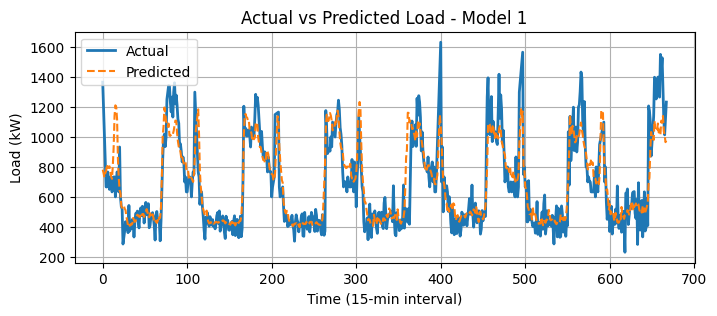

Fitting 3 folds for each of 80 candidates, totalling 240 fits


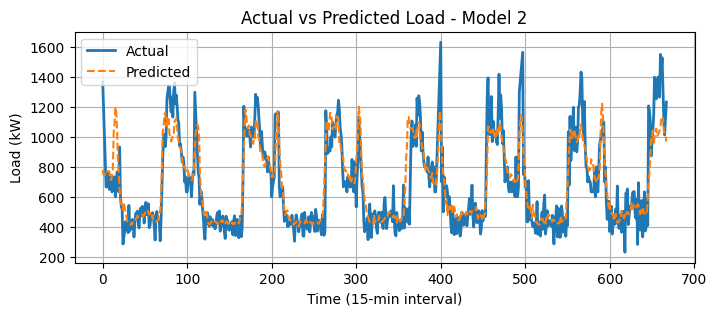

Fitting 3 folds for each of 80 candidates, totalling 240 fits


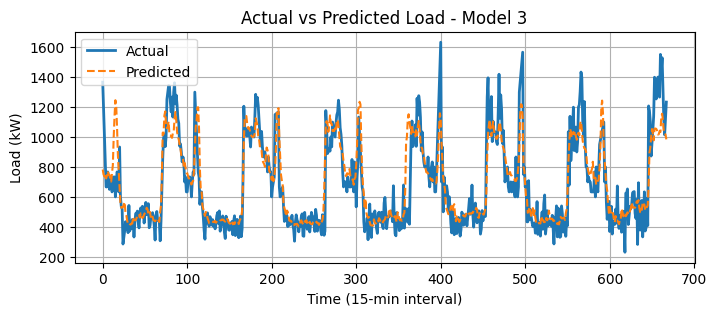

Fitting 3 folds for each of 80 candidates, totalling 240 fits


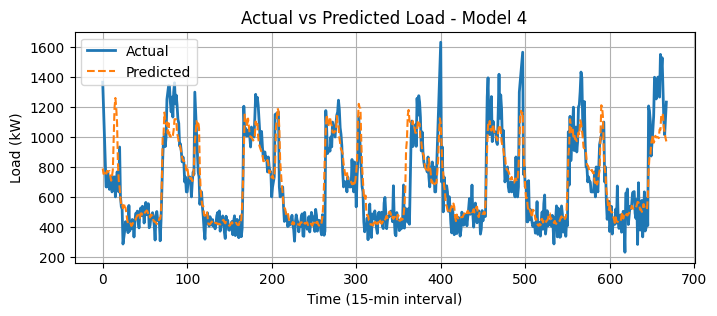

Fitting 3 folds for each of 80 candidates, totalling 240 fits


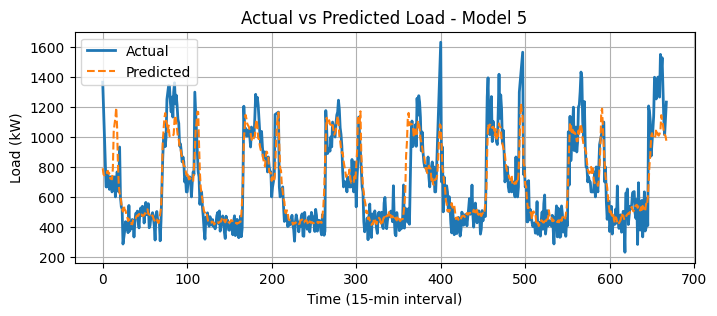

     Model           MSE        RMSE         MAE        R2       MAPE
0  Model 1  22260.103787  149.198203  103.390647  0.756913  15.848956
1  Model 2  21584.442597  146.916448  101.593616  0.764291  15.709363
2  Model 3  21681.697394  147.247062  100.717267  0.763229  15.572156
3  Model 4  21799.147502  147.645344  100.892061  0.761947  15.591288
4  Model 5  21164.005502  145.478540   99.407633  0.768882  15.319874


In [2]:

if __name__ == "__main__":
    # Load data
    train_data = pd.read_csv("train_delta_o.csv")
    test_data = pd.read_csv("test_delta_o.csv")
    
    features_to_keep = ['Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7','Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
                        'relative_humidity', 'clearsky_dni','zenith',
                        'Day','Month','D_1_h','D_2_h','D_3_h',
                        'uv_index','dewpoint_temp','Hour','Minute']
    train_data = train_data[features_to_keep]
    test_data = test_data[features_to_keep]

    # Initialize manager
    manager = ModelManager(train_data, test_data, features_to_keep, window_size=4, target_step=0)
    X_train, X_test, y_train, y_test = manager.preprocess_data()

    # Model 1
    param_dist1 = {
        'estimator__max_depth': (2, 70),
        'estimator__min_samples_split': [2, 3, 4, 5, 6],
        'estimator__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
        'estimator__splitter': ['best', 'random'],
        'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
        'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
    }
    manager.train_model("Model 1", param_dist1, n_estimators=40, random_state=76, X_train=X_train, y_train=y_train)
    manager.predict("Model 1", X_test, y_test)
    manager.plot_results("Model 1", y_test)

    # Model 2
    param_dist2 = {
        'estimator__max_depth': (2, 80),
        'estimator__min_samples_split': [2, 9],
        'estimator__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
        'estimator__splitter': ['best', 'random'],
        'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
        'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
    }
    manager.train_model("Model 2", param_dist2, n_estimators=50, random_state=57, X_train=X_train, y_train=y_train)
    manager.predict("Model 2", X_test, y_test)
    manager.plot_results("Model 2", y_test)

    # Model 3
    param_dist3 = {
        'estimator__max_depth': (2, 80),
        'estimator__min_samples_split': [2, 3, 4, 5],
        'estimator__min_samples_leaf': [2, 3, 4, 5, 6],
        'estimator__splitter': ['best', 'random'],
        'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
        'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
    }

    manager.train_model("Model 3", param_dist3, n_estimators=70, random_state=65, X_train=X_train, y_train=y_train)
    manager.predict("Model 3", X_test, y_test)
    manager.plot_results("Model 3", y_test)
     # Model 4
    param_dist4 = {
    'estimator__max_depth': (2,70),
    'estimator__min_samples_split': (2,3,4,5),
    'estimator__min_samples_leaf': [2, 3, 4, 5, 6],
    'estimator__splitter': ['best', 'random'],
    'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
    'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
    }
    manager.train_model("Model 4", param_dist4, n_estimators=60, random_state=60, X_train=X_train, y_train=y_train)
    manager.predict("Model 4", X_test, y_test)
    manager.plot_results("Model 4", y_test)
    # Model 5
    param_dist5 = {
    'estimator__max_depth': (2,90),
    'estimator__min_samples_split': (2,3,4,5,6,7,8),
    'estimator__min_samples_leaf': [2, 3, 4, 5, 6,7],
    'estimator__splitter': ['best', 'random'],
    'estimator__criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
    'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
}
    manager.train_model("Model 5", param_dist5, n_estimators=50, random_state=74, X_train=X_train, y_train=y_train)
    manager.predict("Model 5", X_test, y_test)
    manager.plot_results("Model 5", y_test)
    # Summarize all results
    manager.summarize_results()


**Decision Tree - Test**

Training Model 1...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model 1 - MAPE: 15.742246101401843%


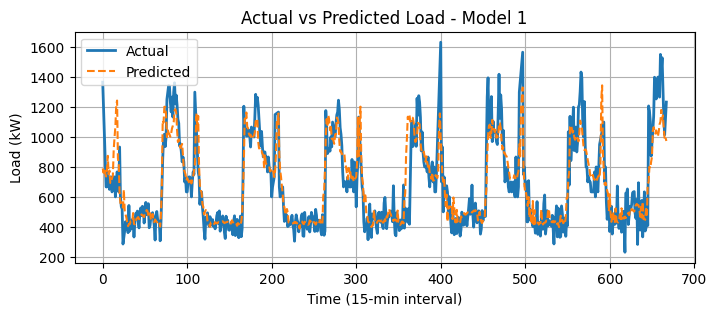

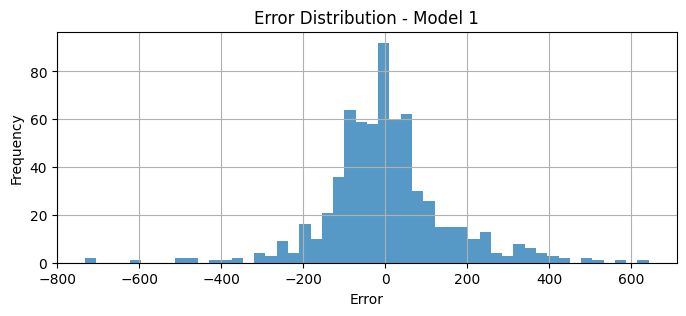

Training Model 2...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model 2 - MAPE: 15.9331193353505%


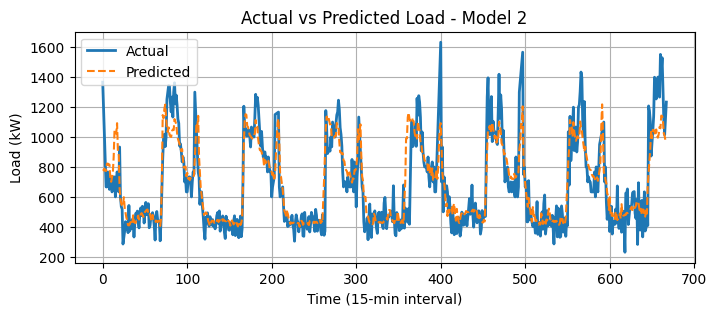

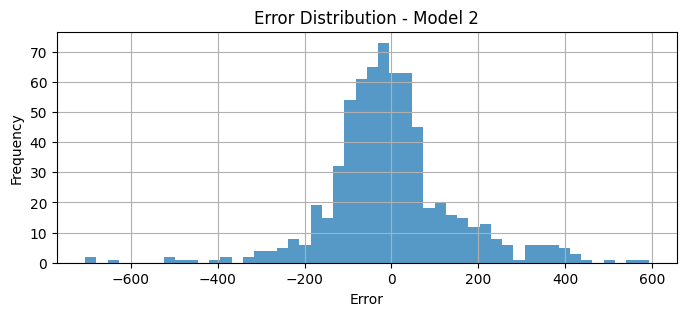

Training Model 3...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model 3 - MAPE: 15.845721761128878%


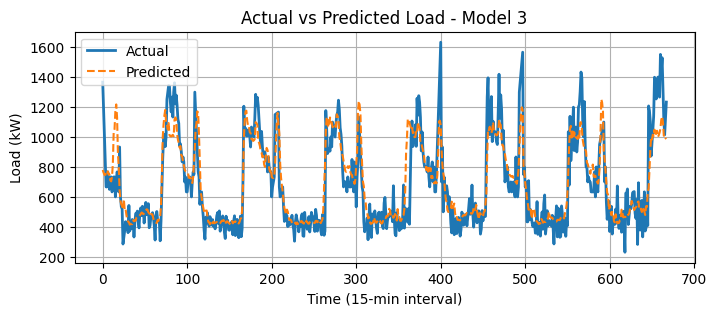

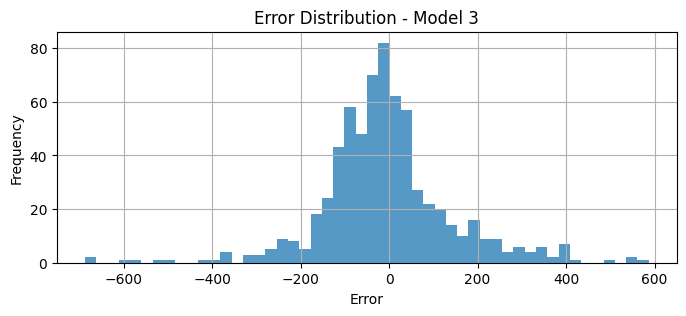

Training Model 4...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model 4 - MAPE: 15.188840168582034%


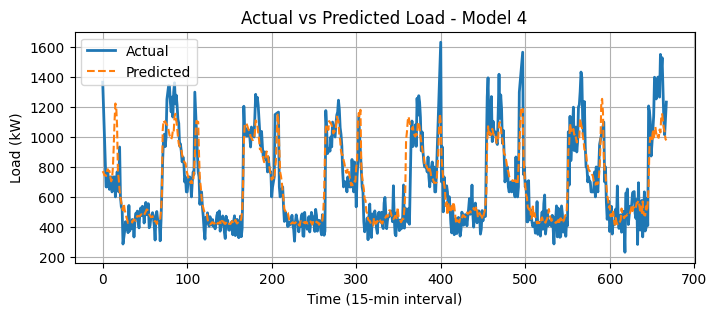

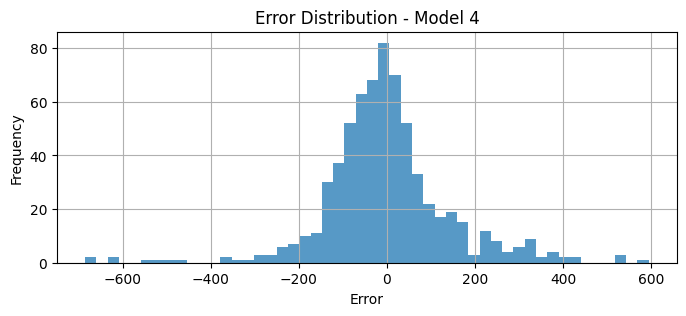

Training Model 5...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Model 5 - MAPE: 15.308595054341792%


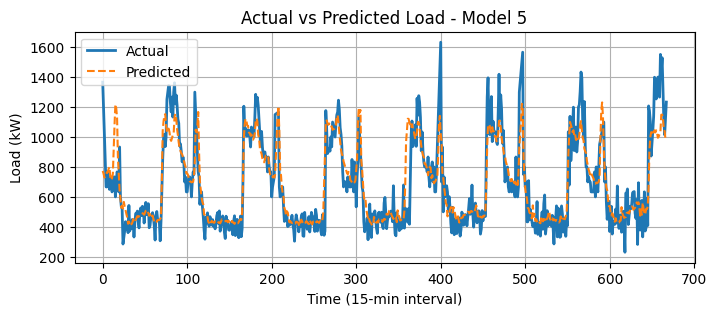

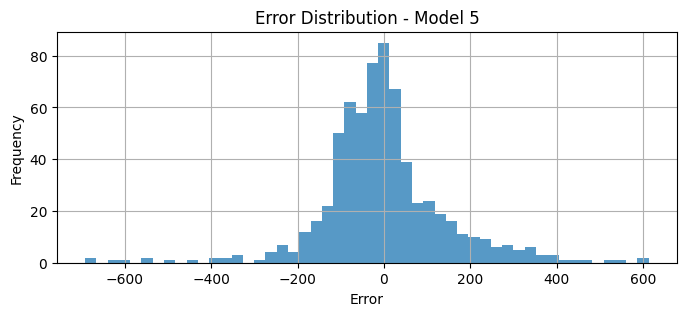

Best model: Model 4 with MAPE = 15.188840168582034%


In [8]:
if __name__ == "__main__":
    # Load data
    train_data = pd.read_csv("train_delta_o.csv")
    test_data = pd.read_csv("test_delta_o.csv")
    
    features_to_keep = ['Load','D_1','D_2','D_3','D_4','D_5','D_6','D_7','Pc_1','Pc_2','Pc_3','Pc_4','Pc_5','Pc_6','Pc_7',
                        'relative_humidity', 'clearsky_dni','zenith',
                        'Day','Month','D_1_h','D_2_h','D_3_h',
                        'uv_index','dewpoint_temp','Hour','Minute']
    train_data = train_data[features_to_keep]
    test_data = test_data[features_to_keep]

    # Initialize manager
    manager = ModelManager(train_data, test_data, features_to_keep, window_size=4, target_step=0)
    X_train, X_test, y_train, y_test = manager.preprocess_data()

    # Parameter distributions for all models
    param_distributions = [
        {
            'estimator__max_depth': (2, 70),
            'estimator__min_samples_split': [2, 3, 4, 5, 6],
            'estimator__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
            'estimator__splitter': ['best', 'random'],
            'estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
        },
        {
            'estimator__max_depth': (2, 80),
            'estimator__min_samples_split': [2, 9],
            'estimator__min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9],
            'estimator__splitter': ['best', 'random'],
            'estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
        },
        {
            'estimator__max_depth': (2, 80),
            'estimator__min_samples_split': [2, 3, 4, 5],
            'estimator__min_samples_leaf': [2, 3, 4, 5, 6],
            'estimator__splitter': ['best', 'random'],
            'estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
        },
        {
            'estimator__max_depth': (2, 70),
            'estimator__min_samples_split': [2, 3, 4, 5],
            'estimator__min_samples_leaf': [2, 3, 4, 5, 6],
            'estimator__splitter': ['best', 'random'],
            'estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
        },
        {
            'estimator__max_depth': (2, 90),
            'estimator__min_samples_split': [2, 3, 4, 5, 6, 7, 8],
            'estimator__min_samples_leaf': [2, 3, 4, 5, 6, 7],
            'estimator__splitter': ['best', 'random'],
            'estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'estimator__max_features': [None, 'sqrt', 'log2', 0.5, 0.7, 0.9]
        }
    ]

    # Initialize the best MAPE tracker
    best_mape = float('inf')
    best_model_name = None

    # Loop over models
    for i, param_dist in enumerate(param_distributions, start=1):
        model_name = f"Model {i}"
        print(f"Training {model_name}...")

        # Train model
        manager.train_model(model_name, param_dist, n_estimators=40 + 10 * i, random_state=76 + i, X_train=X_train, y_train=y_train)
        
        # Predict and evaluate
        manager.predict(model_name, X_test, y_test)
        
        # Check MAPE
        mape = manager.results[model_name]["metrics"]["MAPE"]
        print(f"{model_name} - MAPE: {mape}%")

        # Update the best model if this one is better
        if mape < best_mape:
            best_mape = mape
            best_model_name = model_name

        # Plot results
        manager.plot_results(model_name, y_test)

        # Stop if MAPE < 12% or no further improvement is possible
        if mape < 12:
            print(f"Success: {model_name} achieved MAPE < 12%")
            break

    print(f"Best model: {best_model_name} with MAPE = {best_mape}%")



In [10]:

test_data['Year'] = 2024
test_data['Date'] = pd.to_datetime(test_data[['Year', 'Month', 'Day']])

dates = test_data['Date'][manager.window_size + manager.target_step:].reset_index(drop=True)

daily_mape_results = {}

for model_name, result in manager.results.items():
    y_pred = result['y_pred']
    y_test_df = pd.DataFrame({
        'Date': dates,
        'y_test': y_test,
        'y_pred': y_pred
    })

    daily_mape = y_test_df.groupby('Date').apply(
        lambda x: np.mean(np.abs((x['y_test'] - x['y_pred']) / x['y_test'])) * 100
    )
    daily_mape_results[model_name] = daily_mape

mape_summary = pd.DataFrame(daily_mape_results)
mape_summary.reset_index(inplace=True)
mape_summary


,Date,Model 1,Model 2,Model 3,Model 4,Model 5
0,2024-11-14,17.263938,17.076880,17.522369,16.666380,17.048032
1,2024-11-15,10.597690,10.898644,11.321821,10.609597,10.449657
2,2024-11-16,12.374174,12.974682,12.235192,12.049857,12.523313
3,2024-11-19,21.024543,21.303184,21.305766,20.700578,20.849474
4,2024-11-20,13.494118,13.612777,12.993491,12.760181,12.749410
5,2024-11-21,15.883879,16.395872,16.436964,15.487651,15.444786
6,2024-11-22,19.620784,19.317452,19.174309,18.109202,18.167970


In [11]:
y_pred3 = manager.results["Model 3"]["y_pred"]
y_pred3

array([ 779.7670491 ,  762.52460369,  748.30561976,  753.23669417,
        738.82059438,  748.01756615,  771.04207984,  748.26933045,
        750.87819925,  710.25337618,  703.69893466,  732.98763381,
        821.11730011, 1036.47553137, 1053.10060697, 1176.23013572,
       1217.66631926, 1130.75341333,  889.61160461,  797.86168301,
        646.3352209 ,  574.45823651,  549.94101028,  537.85309749,
        515.37439059,  584.28940838,  514.59584971,  522.61859899,
        480.34692072,  447.68853212,  435.36678729,  430.3216486 ,
        414.70398485,  420.2332175 ,  418.19141419,  418.35281943,
        443.65488711,  437.08429182,  444.40123997,  441.17654311,
        463.82039305,  469.82544479,  470.77014595,  471.10377246,
        477.543576  ,  485.18694236,  495.58844614,  493.31392738,
        485.08266741,  489.26047889,  503.63660022,  508.51586463,
        517.18508471,  514.03801847,  497.70195102,  490.73718609,
        482.52413799,  469.86392532,  485.72433634,  480.60354

## Random Forest

Training data shape: (3836, 104)
Testing data shape: (668, 104)
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
MSE: 22028.83373062536
RMSE: 148.42113640120587
MAE: 103.68036897571727
R2: 0.7594382784937649
MAPE: 16.336794408734416
Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


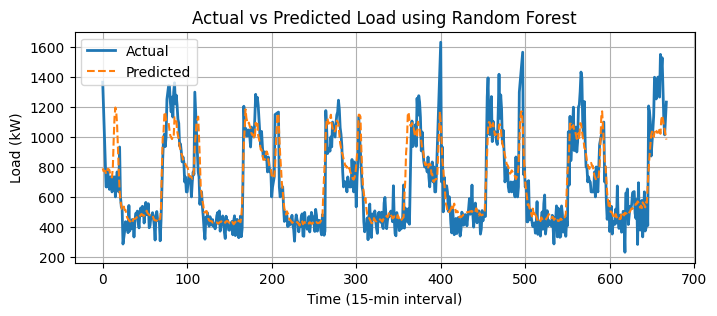

In [18]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv("train_delta_o.csv")
test_data = pd.read_csv("test_delta_o.csv")

# Features to keep
features_to_keep = ['Load', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'Pc_1',
                    'Pc_2', 'Pc_3', 'Pc_4', 'Pc_5', 'Pc_6', 'Pc_7',
                    'relative_humidity', 'clearsky_dni', 'zenith', 'Day', 'Month', 'D_1_h', 'D_2_h', 'D_3_h',
                    'uv_index', 'dewpoint_temp', 'Hour', 'Minute']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep]

# Handle missing values if any
if train_data.isnull().values.any() or test_data.isnull().values.any():
    train_data.fillna(method='ffill', inplace=True)
    test_data.fillna(method='ffill', inplace=True)

# Define sliding window function
def create_sliding_window(data, window_size, target_step):
    X, y = [], []
    for i in range(len(data) - window_size - target_step):
        X.append(data.iloc[i:i+window_size, 1:].values.flatten())  
        y.append(data['Load'].iloc[i+window_size+target_step])  
    return np.array(X), np.array(y)

# Parameters
window_size = 4  
target_step = 0  

# Create sliding windows
X_train, y_train = create_sliding_window(train_data, window_size, target_step)
X_test, y_test = create_sliding_window(test_data, window_size, target_step)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

# Parameter distribution
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 20, 30, 50, None],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# RandomizedSearchCV
n_iter_search = 200  # Increase for more exploration
random_state = 42
rf_model = RandomForestRegressor(random_state=random_state)
random_search_rf = RandomizedSearchCV(
    rf_model, param_distributions=param_dist_rf, n_iter=n_iter_search,
    scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=random_state, n_jobs=-1
)

# Fit model
random_search_rf.fit(X_train_scaled, y_train)
best_rf_model = random_search_rf.best_estimator_

# Make predictions
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print("MSE:", mse_rf)
print("RMSE:", rmse_rf)
print("MAE:", mae_rf)
print("R2:", r2_rf)
print("MAPE:", mape_rf)
print("Best parameters:", random_search_rf.best_params_)

# Plot Actual vs Predicted
plt.figure(figsize=(8, 3))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred_rf, label='Predicted', linestyle='--')
plt.legend()
plt.xlabel("Time (15-min interval)")
plt.ylabel("Load (kW)")
plt.title("Actual vs Predicted Load using Random Forest")
plt.grid()
plt.show()



## XGBoost Model

Training data shape: (3836, 104)
Testing data shape: (668, 104)
Training XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Results for XGBoost:
MSE: 24560.32012045102
RMSE: 156.71732552736796
MAE: 111.02370303857774
R2: 0.7317936591120571
MAPE: 17.498937511299797


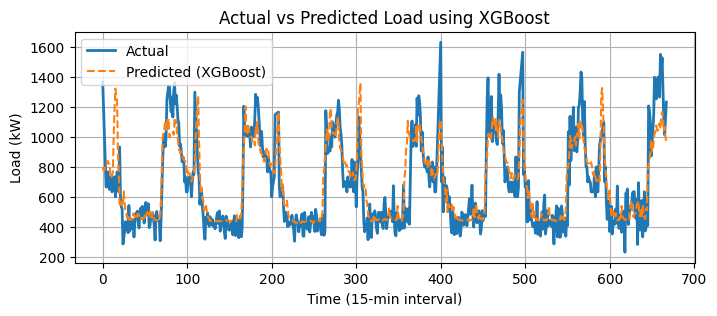

In [19]:
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv("train_delta_o.csv")
test_data = pd.read_csv("test_delta_o.csv")

# Features to keep
features_to_keep = ['Load', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'Pc_1',
                    'Pc_2', 'Pc_3', 'Pc_4', 'Pc_5', 'Pc_6', 'Pc_7',
                    'relative_humidity', 'clearsky_dni', 'zenith', 'Day', 'Month', 'D_1_h', 'D_2_h', 'D_3_h',
                    'uv_index', 'dewpoint_temp', 'Hour', 'Minute']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep]

# Handle missing values if any
if train_data.isnull().values.any() or test_data.isnull().values.any():
    train_data.fillna(method='ffill', inplace=True)
    test_data.fillna(method='ffill', inplace=True)

# Define sliding window function
def create_sliding_window(data, window_size, target_step):
    X, y = [], []
    for i in range(len(data) - window_size - target_step):
        X.append(data.iloc[i:i+window_size, 1:].values.flatten())  
        y.append(data['Load'].iloc[i+window_size+target_step])  
    return np.array(X), np.array(y)

# Parameters
window_size = 4  
target_step = 0  

# Create sliding windows
X_train, y_train = create_sliding_window(train_data, window_size, target_step)
X_test, y_test = create_sliding_window(test_data, window_size, target_step)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

# XGBoost Parameter distribution
param_dist_xgb = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 5]
}

# Train XGBoost
print("Training XGBoost...")
random_state_xgb = 42
xgb_model = XGBRegressor(random_state=random_state_xgb)
random_search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist_xgb, n_iter=100,
    scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=random_state_xgb, n_jobs=-1
)
random_search_xgb.fit(X_train_scaled, y_train)
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"Results for {model_name}:")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2:", r2)
    print("MAPE:", mape)
    return mse, rmse, mae, r2, mape

# XGBoost Results
xgb_results = evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Plot Actual vs Predicted for XGBoost
plt.figure(figsize=(8, 3))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred_xgb, label='Predicted (XGBoost)', linestyle='--')
plt.legend()
plt.xlabel("Time (15-min interval)")
plt.ylabel("Load (kW)")
plt.title("Actual vs Predicted Load using XGBoost")
plt.grid()
plt.show()



## LightGBM 

Training data shape: (3836, 104)
Testing data shape: (668, 104)
Training XGBoost...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Results for XGBoost:
MSE: 24560.32012045102
RMSE: 156.71732552736796
MAE: 111.02370303857774
R2: 0.7317936591120571
MAPE: 17.498937511299797


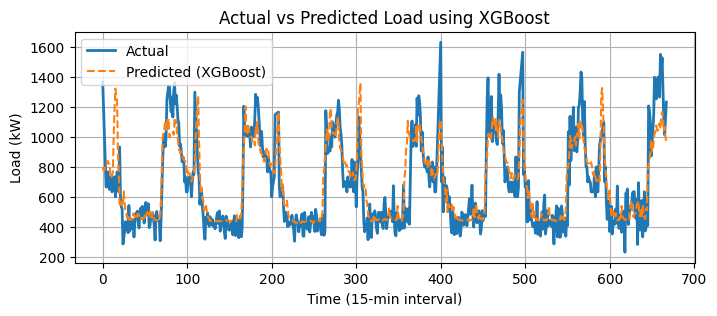

In [20]:
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv("train_delta_o.csv")
test_data = pd.read_csv("test_delta_o.csv")

# Features to keep
features_to_keep = ['Load', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'Pc_1',
                    'Pc_2', 'Pc_3', 'Pc_4', 'Pc_5', 'Pc_6', 'Pc_7',
                    'relative_humidity', 'clearsky_dni', 'zenith', 'Day', 'Month', 'D_1_h', 'D_2_h', 'D_3_h',
                    'uv_index', 'dewpoint_temp', 'Hour', 'Minute']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep]

# Handle missing values if any
if train_data.isnull().values.any() or test_data.isnull().values.any():
    train_data.fillna(method='ffill', inplace=True)
    test_data.fillna(method='ffill', inplace=True)

# Define sliding window function
def create_sliding_window(data, window_size, target_step):
    X, y = [], []
    for i in range(len(data) - window_size - target_step):
        X.append(data.iloc[i:i+window_size, 1:].values.flatten())  
        y.append(data['Load'].iloc[i+window_size+target_step])  
    return np.array(X), np.array(y)

# Parameters
window_size = 4  
target_step = 0  

# Create sliding windows
X_train, y_train = create_sliding_window(train_data, window_size, target_step)
X_test, y_test = create_sliding_window(test_data, window_size, target_step)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

# XGBoost Parameter distribution
param_dist_xgb = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [1, 1.5, 2, 5]
}

# Train XGBoost
print("Training XGBoost...")
random_state_xgb = 42
xgb_model = XGBRegressor(random_state=random_state_xgb)
random_search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist_xgb, n_iter=100,
    scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=random_state_xgb, n_jobs=-1
)
random_search_xgb.fit(X_train_scaled, y_train)
best_xgb_model = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_scaled)

# Evaluate the XGBoost model
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"Results for {model_name}:")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2:", r2)
    print("MAPE:", mape)
    return mse, rmse, mae, r2, mape

# XGBoost Results
xgb_results = evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Plot Actual vs Predicted for XGBoost
plt.figure(figsize=(8, 3))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred_xgb, label='Predicted (XGBoost)', linestyle='--')
plt.legend()
plt.xlabel("Time (15-min interval)")
plt.ylabel("Load (kW)")
plt.title("Actual vs Predicted Load using XGBoost")
plt.grid()
plt.show()



## CatBoost

Training data shape: (3836, 104)
Testing data shape: (668, 104)
Training CatBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Results for CatBoost:
MSE: 23167.80244563594
RMSE: 152.20973177046184
MAE: 105.91302059249855
R2: 0.7470003855859904
MAPE: 16.363075079476516


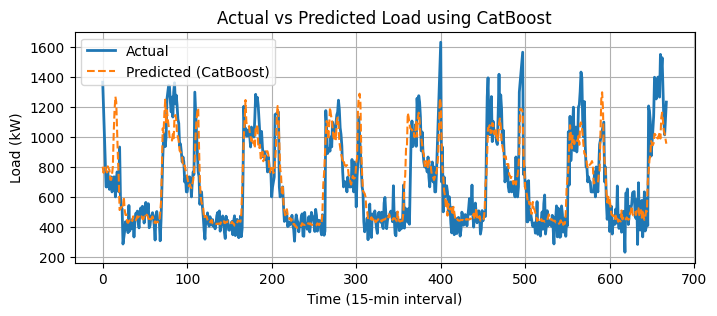

In [23]:
from catboost import CatBoostRegressor
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv("train_delta_o.csv")
test_data = pd.read_csv("test_delta_o.csv")

# Features to keep
features_to_keep = ['Load', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'Pc_1',
                    'Pc_2', 'Pc_3', 'Pc_4', 'Pc_5', 'Pc_6', 'Pc_7',
                    'relative_humidity', 'clearsky_dni', 'zenith', 'Day', 'Month', 'D_1_h', 'D_2_h', 'D_3_h',
                    'uv_index', 'dewpoint_temp', 'Hour', 'Minute']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep]

# Handle missing values if any
if train_data.isnull().values.any() or test_data.isnull().values.any():
    train_data.fillna(method='ffill', inplace=True)
    test_data.fillna(method='ffill', inplace=True)

# Define sliding window function
def create_sliding_window(data, window_size, target_step):
    X, y = [], []
    for i in range(len(data) - window_size - target_step):
        X.append(data.iloc[i:i+window_size, 1:].values.flatten())  
        y.append(data['Load'].iloc[i+window_size+target_step])  
    return np.array(X), np.array(y)

# Parameters
window_size = 4  
target_step = 0  

# Create sliding windows
X_train, y_train = create_sliding_window(train_data, window_size, target_step)
X_test, y_test = create_sliding_window(test_data, window_size, target_step)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

# CatBoost Parameter distribution
param_dist_cb = {
    'iterations': [200, 300, 500, 700, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 1, 2, 3, 5],
}

# Train CatBoost
print("Training CatBoost...")
random_state_cb = 42
cb_model = CatBoostRegressor(verbose=0, random_state=random_state_cb)
random_search_cb = RandomizedSearchCV(
    cb_model, param_distributions=param_dist_cb, n_iter=50,
    scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=random_state_cb, n_jobs=-1
)
random_search_cb.fit(X_train_scaled, y_train)
best_cb_model = random_search_cb.best_estimator_
y_pred_cb = best_cb_model.predict(X_test_scaled)

# Evaluate the CatBoost model
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"Results for {model_name}:")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2:", r2)
    print("MAPE:", mape)
    return mse, rmse, mae, r2, mape

# CatBoost Results
cb_results = evaluate_model(y_test, y_pred_cb, "CatBoost")

# Plot Actual vs Predicted for CatBoost
plt.figure(figsize=(8, 3))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred_cb, label='Predicted (CatBoost)', linestyle='--')
plt.legend()
plt.xlabel("Time (15-min interval)")
plt.ylabel("Load (kW)")
plt.title("Actual vs Predicted Load using CatBoost")
plt.grid()
plt.show()

## SVM

Training data shape: (3836, 104)
Testing data shape: (668, 104)
Training SVM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Results for SVM:
MSE: 25654.6057419883
RMSE: 160.17055204371465
MAE: 104.56111480611996
R2: 0.7198437194940301
MAPE: 15.239971756623738


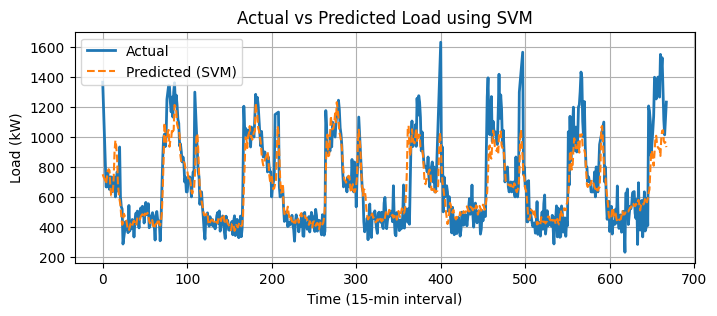

In [24]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv("train_delta_o.csv")
test_data = pd.read_csv("test_delta_o.csv")

# Features to keep
features_to_keep = ['Load', 'D_1', 'D_2', 'D_3', 'D_4', 'D_5', 'D_6', 'D_7', 'Pc_1',
                    'Pc_2', 'Pc_3', 'Pc_4', 'Pc_5', 'Pc_6', 'Pc_7',
                    'relative_humidity', 'clearsky_dni', 'zenith', 'Day', 'Month', 'D_1_h', 'D_2_h', 'D_3_h',
                    'uv_index', 'dewpoint_temp', 'Hour', 'Minute']

train_data = train_data[features_to_keep]
test_data = test_data[features_to_keep]

# Handle missing values if any
if train_data.isnull().values.any() or test_data.isnull().values.any():
    train_data.fillna(method='ffill', inplace=True)
    test_data.fillna(method='ffill', inplace=True)

# Define sliding window function
def create_sliding_window(data, window_size, target_step):
    X, y = [], []
    for i in range(len(data) - window_size - target_step):
        X.append(data.iloc[i:i+window_size, 1:].values.flatten())  
        y.append(data['Load'].iloc[i+window_size+target_step])  
    return np.array(X), np.array(y)

# Parameters
window_size = 4  
target_step = 0  

# Create sliding windows
X_train, y_train = create_sliding_window(train_data, window_size, target_step)
X_test, y_test = create_sliding_window(test_data, window_size, target_step)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")

# SVM Parameter distribution
param_dist_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Train SVM
print("Training SVM...")
random_state_svm = 42
svm_model = SVR()
random_search_svm = RandomizedSearchCV(
    svm_model, param_distributions=param_dist_svm, n_iter=50,
    scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=random_state_svm, n_jobs=-1
)
random_search_svm.fit(X_train_scaled, y_train)
best_svm_model = random_search_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_scaled)

# Evaluate the SVM model
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"Results for {model_name}:")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2:", r2)
    print("MAPE:", mape)
    return mse, rmse, mae, r2, mape

# SVM Results
svm_results = evaluate_model(y_test, y_pred_svm, "SVM")

# Plot Actual vs Predicted for SVM
plt.figure(figsize=(8, 3))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred_svm, label='Predicted (SVM)', linestyle='--')
plt.legend()
plt.xlabel("Time (15-min interval)")
plt.ylabel("Load (kW)")
plt.title("Actual vs Predicted Load using SVM")
plt.grid()
plt.show()


## Extreme learning machine (ELM)

In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ExtremeLearningMachine:
    def __init__(self, n_hidden_neurons, activation='sigmoid'):
        self.n_hidden_neurons = n_hidden_neurons
        self.activation = activation
        self.input_weights = None
        self.biases = None
        self.beta = None

    def _activation_function(self, X):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-X))
        elif self.activation == 'tanh':
            return np.tanh(X)
        elif self.activation == 'relu':
            return np.maximum(0, X)
        else:
            raise ValueError("Unsupported activation function")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.input_weights = np.random.normal(size=(n_features, self.n_hidden_neurons))
        self.biases = np.random.normal(size=(self.n_hidden_neurons,))
        
        H = self._activation_function(np.dot(X, self.input_weights) + self.biases)
        self.beta = np.dot(np.linalg.pinv(H), y)

    def predict(self, X):
        H = self._activation_function(np.dot(X, self.input_weights) + self.biases)
        return np.dot(H, self.beta)

# Example Usage
window_size = 4
target_step = 0

# Prepare sliding window data (same as above)
X_train, y_train = create_sliding_window(train_data, window_size, target_step)
X_test, y_test = create_sliding_window(test_data, window_size, target_step)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train ELM
elm = ExtremeLearningMachine(n_hidden_neurons=100, activation='sigmoid')
elm.fit(X_train_scaled, y_train)

# Predict
y_pred_elm = elm.predict(X_test_scaled)

# Evaluate
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"Results for {model_name}:")
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2:", r2)
    print("MAPE:", mape)
    return mse, rmse, mae, r2, mape

elm_results = evaluate_model(y_test, y_pred_elm, "Manual ELM")


Results for Manual ELM:
MSE: 39766.6752591682
RMSE: 199.41583502612875
MAE: 140.2929075959388
R2: 0.565735527540643
MAPE: 21.434029254030193
